In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspologic.plot import pairplot
from sklearn.manifold import spectral_embedding
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.11/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [2]:
n_verts = 100
n_sims = 5
labels_sbm = n_verts * [0] + n_verts * [1]
embed_methods = ["ase", "lse", "sklearn"]

In [3]:
def calc_error(Xhat):
    labels_kmeans = KMeans(n_clusters=2, n_init=10).fit_predict(Xhat)
    ari = adjusted_rand_score(labels_sbm, labels_kmeans)
    error = labels_sbm - labels_kmeans
    error = error != 0
    # sometimes the labels given by kmeans will be the inverse of ours
    if np.sum(error) / (2 * n_verts) > 0.5:
        error = error == 0
    error_rate = np.sum(error) / (2 * n_verts)
    error_label = (2 * n_verts) * ['Right']
    error_label = np.array(error_label)
    error_label[error] = 'Wrong'
    return ari, error_rate, error_label

In [4]:
#undirected testing
undirected_rows = []

for insularity in np.linspace(0.5, 0.625, 8):
    P = np.array([[insularity, 1-insularity], [1-insularity, insularity]])
    sampled_sbm = sbm(2 * [n_verts], P)

    for name in embed_methods:
        for sim in range(n_sims):
            #choose embedding method
            if name == "ase":
                ase = AdjacencySpectralEmbed(n_components=2)
                Xhat = ase.fit_transform(sampled_sbm)
            elif name == "lse":
                lse = LaplacianSpectralEmbed(n_components=2)
                Xhat = lse.fit_transform(sampled_sbm)
            elif name == "sklearn":
                Xhat = spectral_embedding(sampled_sbm, n_components=2)
            ari, error_rate, error_label = calc_error(Xhat)
            result = {
                "test": name,
                "insularity": insularity,
                "ari": ari,
                "error_rate": error_rate,
                #"error_label": error_label,
            }
        undirected_rows.append(result)
undirected_results = pd.DataFrame(undirected_rows)
undirected_results
    

,test,insularity,ari,error_rate
0,ase,0.500000,0.003131,0.455
1,lse,0.500000,-0.005048,0.500
2,sklearn,0.500000,0.003131,0.455
3,ase,0.517857,-0.004630,0.490
4,lse,0.517857,-0.002537,0.475
5,sklearn,0.517857,-0.001268,0.470
6,ase,0.535714,0.172255,0.290
7,lse,0.535714,0.009520,0.440
8,sklearn,0.535714,0.079486,0.355
9,ase,0.553571,0.515968,0.140


In [5]:
undirected_means = undirected_results.groupby(["test", "insularity"]).mean()
undirected_means

ari  error_rate
test    insularity                      
ase     0.500000    0.003131       0.455
        0.517857   -0.004630       0.490
        0.535714    0.172255       0.290
        0.553571    0.515968       0.140
        0.571429    0.883012       0.030
        0.589286    0.940602       0.015
        0.607143    1.000000       0.000
        0.625000    1.000000       0.000
lse     0.500000   -0.005048       0.500
        0.517857   -0.002537       0.475
        0.535714    0.009520       0.440
        0.553571    0.446119       0.165
        0.571429    0.864218       0.035
        0.589286    0.940602       0.015
        0.607143    1.000000       0.000
        0.625000    1.000000       0.000
sklearn 0.500000    0.003131       0.455
        0.517857   -0.001268       0.470
        0.535714    0.079486       0.355
        0.553571    0.530541       0.135
        0.571429    0.864218       0.035
        0.589286    0.940602       0.015
        0.607143    0.980000       0.005
        0.625000    1.000000       0.000

<Axes: xlabel='insularity', ylabel='ari'>

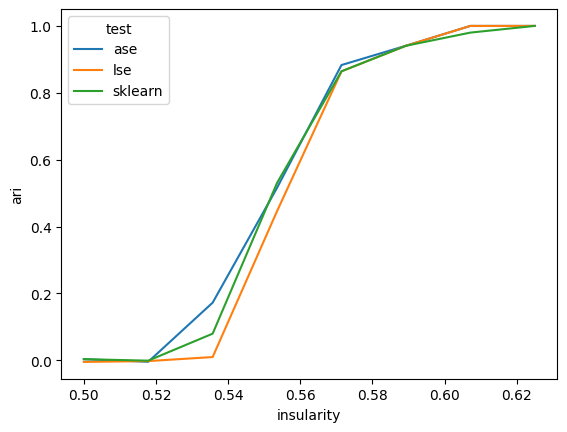

In [6]:
#plot aris
sns.lineplot(data=undirected_means, x="insularity", y="ari", hue="test")

In [10]:
#directed testing
directed_rows = []
for insularity in np.linspace(0.5, 0.625, 8):
    for name in embed_methods:
        for sim in range(n_sims):
            P = np.array([[insularity, 1], [1-insularity, insularity]])
            sampled_sbm = sbm(2 * [n_verts], P, directed=True)

            #choose embedding method
            if name == "ase":
                ase = AdjacencySpectralEmbed(n_components=2)
                Xhat, Yhat = ase.fit_transform(sampled_sbm)
            elif name == "lse":
                lse = LaplacianSpectralEmbed(n_components=2)
                Xhat, Yhat = lse.fit_transform(sampled_sbm)
            elif name == "sklearn":
                Xhat = spectral_embedding(sampled_sbm, n_components=2)
            ari, error_rate, error_label = calc_error(Xhat)
            result = {
                "test": name,
                "insularity": insularity,
                "ari": ari,
                "error_rate": error_rate,
                #"error_label": error_label,
            }
            directed_rows.append(result)
directed_results = pd.DataFrame(directed_rows)
directed_results

/usr/local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247:

,test,insularity,ari,error_rate
0,ase,0.500,1.000000,0.000
1,ase,0.500,1.000000,0.000
2,ase,0.500,1.000000,0.000
3,ase,0.500,1.000000,0.000
4,ase,0.500,1.000000,0.000
...,...,...,...,...
115,sklearn,0.625,-0.002533,0.475
116,sklearn,0.625,0.001414,0.460
117,sklearn,0.625,-0.004630,0.490
118,sklearn,0.625,-0.000125,0.465


In [11]:
directed_means = directed_results.groupby(["test", "insularity"]).mean()
directed_means

ari  error_rate
test    insularity                      
ase     0.500000    1.000000       0.000
        0.517857    0.992000       0.002
        0.535714    0.988000       0.003
        0.553571    0.925366       0.019
        0.571429    0.713805       0.080
        0.589286    0.090724       0.379
        0.607143    0.123122       0.336
        0.625000    0.402984       0.275
lse     0.500000    0.996000       0.001
        0.517857    0.964200       0.009
        0.535714    0.839280       0.042
        0.553571    0.663711       0.093
        0.571429    0.238648       0.273
        0.589286    0.016812       0.437
        0.607143    0.013233       0.436
        0.625000    0.001598       0.464
sklearn 0.500000   -0.003635       0.485
        0.517857   -0.003284       0.487
        0.535714   -0.003822       0.484
        0.553571   -0.002452       0.478
        0.571429   -0.003306       0.483
        0.589286   -0.004713       0.493
        0.607143   -0.001581       0.476
        0.625000   -0.001678       0.473

Text(0.5, 1.0, 'Directed graph')

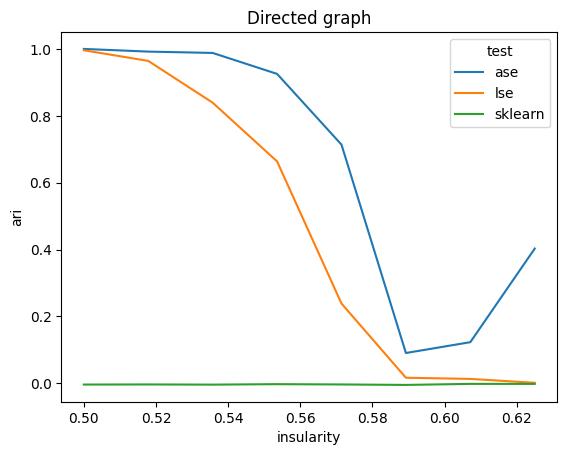

In [12]:
#plot aris
sns.lineplot(data=directed_means, x="insularity", y="ari", hue="test")
plt.title("Directed graph")